# Music Genre Classification

### Model Training

We do model training using following models and check the accuracy.
- DNN
- CNN
- LSTM

### Importing required packages

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Importing data

In [4]:
mfcc_data = np.load('data/mfcc_features.npz')

In [5]:
X = mfcc_data['X_mfcc']
Y = mfcc_data['Y_mfcc']

### Converting categorical label to numerical values

In [6]:
le = LabelEncoder()
Y = le.fit_transform(Y)

In [7]:
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f'Mapping = {mapping}')

Mapping = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


#### Splitting data into train, test, valid

In [8]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=42, stratify=y_train_valid)

In [9]:
print(f'Shape of X_train = {X_train.shape}')
print(f'Shape of y_train = {y_train.shape}')
print(f'Shape of X_valid = {X_valid.shape}')
print(f'Shape of y_valid = {y_valid.shape}')
print(f'Shape of X_test = {X_test.shape}')
print(f'Shape of y_test = {y_test.shape}')

Shape of X_train = (2430, 20, 431)
Shape of y_train = (2430,)
Shape of X_valid = (270, 20, 431)
Shape of y_valid = (270,)
Shape of X_test = (300, 20, 431)
Shape of y_test = (300,)


#### Creating train and valid dataloader

In [13]:
train_data = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = 16,
                                           shuffle = True)

valid_data = torch.utils.data.TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid))
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size = 16,
                                           shuffle = True)

In [10]:
len(train_loader.dataset)

2430

## Models

### Training

In [64]:
def training(model, model_name, loss_fn, optimizer, scheduler, train_data_loader, valid_data_loader, num_epochs = 25, patience = 5):
    min_loss = np.inf
    count = 0
    history = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0 
        
        valid_loss = 0.0
        valid_acc = 0.0
        for _, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            y_preds = model(inputs)
            loss = loss_fn(y_preds, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(inputs)
            correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
            train_acc += correct_counts
        
        with torch.no_grad():
            model.eval()
            for _, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                y_preds = model(inputs)
                loss = loss_fn(y_preds, labels)
                valid_loss += loss.item()*len(inputs)
                correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
                valid_acc += correct_counts
        
        train_loss = train_loss/len(train_data_loader.dataset)
        train_acc = train_acc/len(train_data_loader.dataset)
        
        valid_loss = valid_loss/len(valid_data_loader.dataset)
        valid_acc = valid_acc/len(valid_data_loader.dataset)
        
        history.append([train_acc, train_loss, valid_acc, valid_loss]) 
        print(f'Epoch No. {epoch+1}')
        print(f'Training Accuracy = {train_acc:.4f}, Loss = {train_loss:.4f}')
        print(f'Validation Accuracy = {valid_acc:.4f}, Loss = {valid_loss:.4f}')
        torch.save(model.state_dict(), model_name + '_last_epoch.pt')
        
        scheduler.step(valid_loss)
        
        if (valid_loss < min_loss):
            count = 0 
            min_loss = valid_loss 
            torch.save(model.state_dict(), model_name + '_best_model.pt')
        
        else:
            count += 1
            if (count >= patience):
                print(f'Early stop at Epoch Number. {epoch + 1}')
                break 
        
    return model, history

### Accuracy for test data

In [12]:
test_data = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = 16,
                                           shuffle = True)

In [13]:
def get_accuracy(trained_model, loss_fn, test_data_loader):
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        trained_model.eval()
        for _, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_preds = trained_model(inputs)
            loss = loss_fn(y_preds, labels)
            test_loss += loss.item()*len(inputs)
            correct_counts = (torch.argmax(y_preds.data, 1) == labels).float().sum().item()
            test_acc += correct_counts
    test_loss = test_loss/len(test_data_loader.dataset)
    test_acc = test_acc/len(test_data_loader.dataset)
    print(f'Loss for test set = {test_loss:.4f}')
    print(f'Accuracy for test set = {test_acc:.4f}')
    return test_loss, test_acc

In [14]:
def post_training(trained_model, loss_fn, test_loader, history, model_name):
    test_loss, test_acc = get_accuracy(trained_model, loss_fn, test_loader)
    history_np = np.array(history)
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    epochs_list = np.arange(1, len(history_np)+1)
    axes[0].plot(epochs_list, history_np[:, 0], label = "Training Accuracy", marker = '.')
    axes[0].plot(epochs_list, history_np[:, 2], label = "Validation Accuracy", marker = '.')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(epochs_list, history_np[:, 1], label = "Training Loss", marker = '.')
    axes[1].plot(epochs_list, history_np[:, 3], label = "Validation Loss", marker = '.')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    fig.suptitle(f'Training for {model_name}')
    plt.show()
    return test_loss, test_acc

### 1. DNN

In [15]:
input_size = X_train.shape[1] * X_train.shape[2]
print(f'Input Size = {input_size}')

8620

In [16]:
model_name = 'DNN'
model_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
trained_model1 , history_model1 = training(model_1, 'DNN', loss_fn, optimizer, scheduler, train_loader, valid_loader, 5, 3)

 20%|██        | 1/5 [00:08<00:34,  8.63s/it]

Epoch No. 1
Training Accuracy = 0.3235, Loss = 13.6182
Validation Accuracy = 0.4222, Loss = 1.7237


 40%|████      | 2/5 [00:17<00:25,  8.55s/it]

Epoch No. 2
Training Accuracy = 0.4617, Loss = 1.5460
Validation Accuracy = 0.4407, Loss = 1.5453


 60%|██████    | 3/5 [00:25<00:16,  8.41s/it]

Epoch No. 3
Training Accuracy = 0.5198, Loss = 1.3583
Validation Accuracy = 0.4630, Loss = 1.5548


 80%|████████  | 4/5 [00:33<00:08,  8.38s/it]

Epoch No. 4
Training Accuracy = 0.5979, Loss = 1.1683
Validation Accuracy = 0.5074, Loss = 1.6126


 80%|████████  | 4/5 [00:41<00:10, 10.42s/it]

Epoch No. 5
Training Accuracy = 0.6103, Loss = 1.1533
Validation Accuracy = 0.4852, Loss = 1.6650
Early stop at Epoch Number. 5


Loss for test set = 1.5834
Accuracy for test set = 0.5267


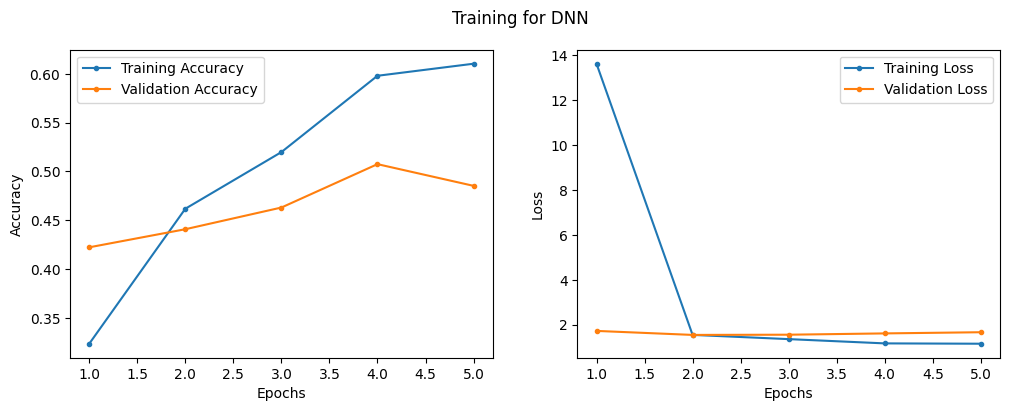

In [17]:
test_loss_1, test_acc_1 = post_training(trained_model1, loss_fn, test_loader, history_model1, 'DNN')

### 2. CNN

### Creating train and valid dataloaders

CNN requires an extra dimension to be added to the data to indicate the channel, we need it for convolution operation

In [30]:
X_train_cnn = np.expand_dims(X_train, 1)
X_valid_cnn = np.expand_dims(X_valid, 1)
train_data_cnn = torch.utils.data.TensorDataset(torch.tensor(X_train_cnn), torch.tensor(y_train))
train_loader_cnn = torch.utils.data.DataLoader(dataset=train_data_cnn,
                                           batch_size = 16,
                                           shuffle = True)

valid_data_cnn = torch.utils.data.TensorDataset(torch.tensor(X_valid_cnn), torch.tensor(y_valid))
valid_loader_cnn = torch.utils.data.DataLoader(dataset=valid_data_cnn,
                                           batch_size = 16,
                                           shuffle = True)

In [128]:
class CNN_music(nn.Module):
    def __init__(self) :
        super(CNN_music, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=256,
                      kernel_size=3,   padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3,   padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256)
        ) 

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=2,   padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(256)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Flatten(),
            nn.Linear(256 * 280, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [130]:
model_2 = CNN_music()
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
trained_model_2 , history_model_2 = training(model_2, 'CNN', loss_fn, optimizer, scheduler, train_loader_cnn, valid_loader_cnn, 5, 3)

  0%|          | 0/5 [00:00<?, ?it/s]

: 

In [ ]:
X_test_cnn = np.expand_dims(X_test, 1)
test_data_cnn = torch.utils.data.TensorDataset(torch.tensor(X_test_cnn), torch.tensor(y_test))
test_loader_cnn = torch.utils.data.DataLoader(dataset=test_data_cnn,
                                           batch_size = 16,
                                           shuffle = True)
test_loss_2, test_acc_2 = post_training(trained_model_2, loss_fn, test_loader_cnn, history_model_2, 'CNN')

### LSTM

In [46]:
X_train_lstm = np.transpose(X_train, (0, 2, 1))
X_valid_lstm = np.transpose(X_valid, (0, 2, 1))
train_data_lstm = torch.utils.data.TensorDataset(torch.tensor(X_train_lstm), torch.tensor(y_train))
train_loader_lstm = torch.utils.data.DataLoader(dataset=train_data_lstm,
                                           batch_size = 16,
                                           shuffle = True)

valid_data_lstm = torch.utils.data.TensorDataset(torch.tensor(X_valid_lstm), torch.tensor(y_valid))
valid_loader_lstm = torch.utils.data.DataLoader(dataset=valid_data_lstm,
                                           batch_size = 16,
                                           shuffle = True)

In [61]:
class LSTM_music(nn.Module):
    def __init__(self):
        super(LSTM_music, self).__init__()
        self.lstm1 = nn.LSTM(input_size=20, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )
    
    def forward(self,x):
        out, _ = self.lstm1(x, )
        out = self.lstm2(out)[0][:, -1, :]
        out = self.fc(out)
        return out

In [65]:
model_3 = LSTM_music()
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr = learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
trained_model_3 , history_model_3 = training(model_3, 'LSTM', loss_fn, optimizer, scheduler, train_loader_lstm, valid_loader_lstm, 5, 3)

 20%|██        | 1/5 [00:19<01:18, 19.65s/it]

Epoch No. 1
Training Accuracy = 0.3251, Loss = 1.8311
Validation Accuracy = 0.4926, Loss = 1.4833


 40%|████      | 2/5 [00:39<00:59, 19.86s/it]

Epoch No. 2
Training Accuracy = 0.4621, Loss = 1.4620
Validation Accuracy = 0.4667, Loss = 1.4542


 60%|██████    | 3/5 [00:59<00:39, 19.96s/it]

Epoch No. 3
Training Accuracy = 0.5008, Loss = 1.3498
Validation Accuracy = 0.5000, Loss = 1.3437


: 

In [ ]:
X_test_lstm = np.transpose(X_train, (0, 2, 1))
test_data_lstm = torch.utils.data.TensorDataset(torch.tensor(X_test_lstm), torch.tensor(y_test))
test_loader_lstm = torch.utils.data.DataLoader(dataset=test_data_lstm,
                                           batch_size = 16,
                                           shuffle = True)
test_loss_3, test_acc_3 = post_training(trained_model_3, loss_fn, test_loader_lstm, history_model_3, 'LSTM')